In [1]:
!pip install -q flwr[simulation] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 12.1 MB/s eta 0:00:00


In [2]:
!pip install alibi-detect[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.41.1
    Uninstalling llvmlite-0.41.1:
      Successfully uninstalled llvmlite-0.41.1
  Attempting uninstall: numba
    Found existing installation: numba 0.58.1
    Uninstalling numba-0.58

In [3]:
import flwr as fl

import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np

from functools import partial
from alibi_detect.cd import MMDDrift
from alibi_detect.cd.pytorch import preprocess_drift

import random
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset

In [4]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
import matplotlib.pyplot as plt

In [5]:
from torch.utils.data import TensorDataset, DataLoader

In [6]:
# set random seed and device
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
print(device)

cuda


In [8]:
n_clients = 2

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
y_train = y_train.astype("int64").reshape(
    -1,
)
y_test = y_test.astype("int64").reshape(
    -1,
)

x_train = x_train[0 : int(len(x_train) * 0.2)]
y_train = y_train[0 : int(len(y_train) * 0.2)] # just to get some small part of data

170498071/170498071 [==============================] - 3s 0us/step


In [10]:
len(x_test)

10000

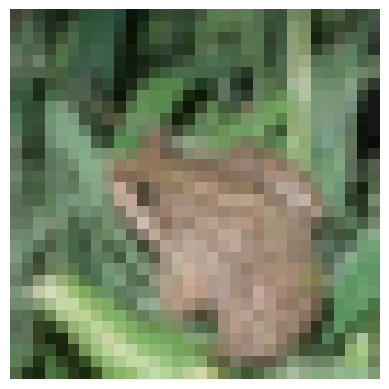

In [11]:
plt.axis('off')
plt.imshow(x_test[4])
plt.show()

In [12]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


In [13]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

In [14]:
len(X_corr)

40000

In [15]:
n_test = x_test.shape[0]
n_corr = len(corruption)

In [16]:
n_test

10000

Client 1 - Reference Dataset Shape: (5000, 32, 32, 3)
Client 1 - H0 Dataset Shape: (5000, 32, 32, 3)
Class Ref H0
0     477 523
1     510 490
2     511 489
3     497 503
4     500 500
5     508 492
6     509 491
7     468 532
8     525 475
9     495 505


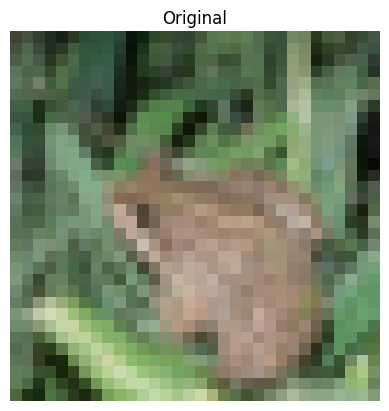

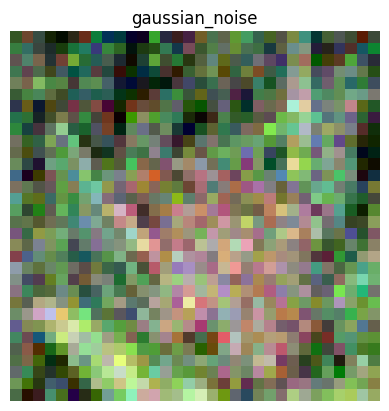

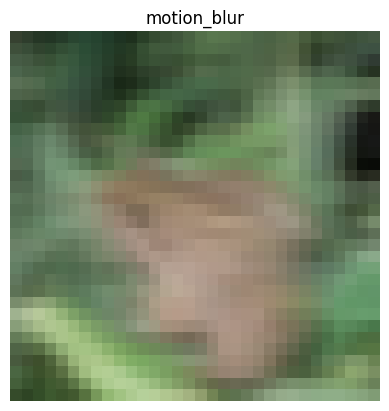

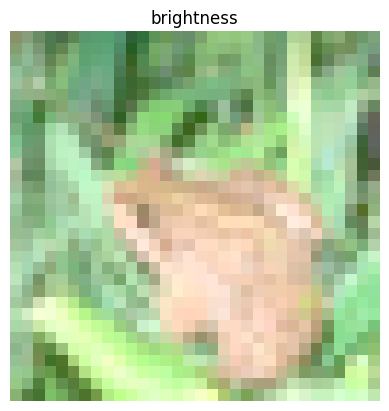

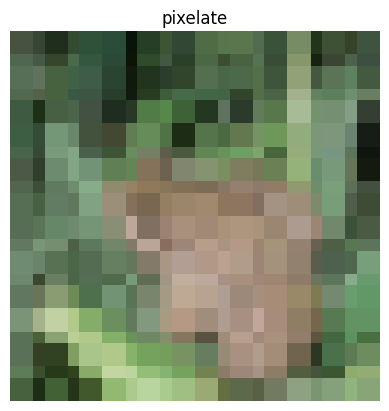

Client 2 - Reference Dataset Shape: (5000, 32, 32, 3)
Client 2 - H0 Dataset Shape: (5000, 32, 32, 3)
Class Ref H0
0     508 492
1     481 519
2     489 511
3     536 464
4     488 512
5     473 527
6     509 491
7     517 483
8     512 488
9     487 513


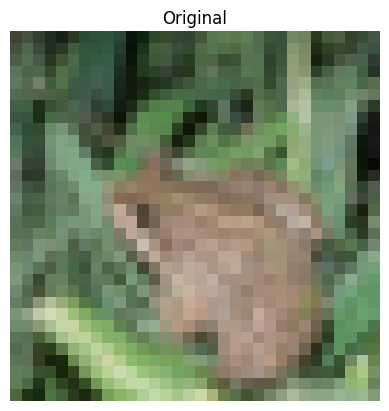

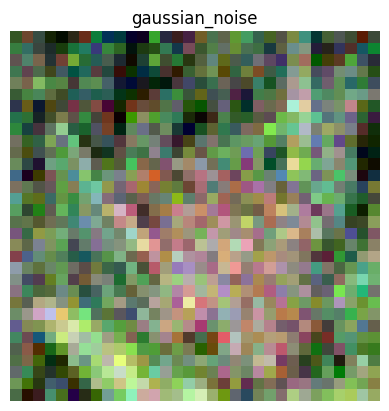

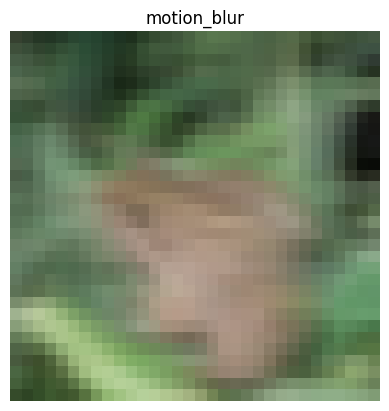

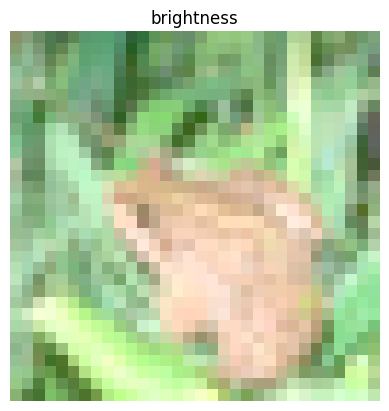

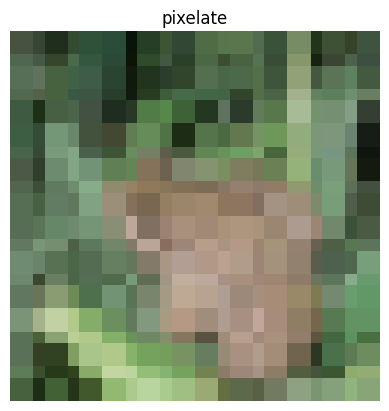

In [17]:
# Simulate federated clients (splitting the dataset)
client_data = []

# Split the original test set into reference and H0 datasets for each client
for i in range(n_clients):
    idx = np.random.choice(n_test, size=n_test // 2, replace=False)
    idx_h0 = np.delete(np.arange(n_test), idx, axis=0)

    # Reference dataset
    X_ref, y_ref = x_test[idx], y_test[idx]

    # Dataset under the H0 of the MMD test
    X_h0, y_h0 = x_test[idx_h0], y_test[idx_h0]

    print(f"Client {i + 1} - Reference Dataset Shape:", X_ref.shape)
    print(f"Client {i + 1} - H0 Dataset Shape:", X_h0.shape)

    # Check class balance
    classes, counts_ref = np.unique(y_ref, return_counts=True)
    counts_h0 = np.unique(y_h0, return_counts=True)[1]

    print('Class Ref H0')
    for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):
        assert cref + ch0 == n_test // 10
        print('{}     {} {}'.format(cl, cref, ch0))

    X_c = [X_corr[i * n_test:(i + 1) * n_test] for i in range(n_corr)]

    client_data.append((X_ref, y_ref, X_h0, y_h0, X_c))

    # Display an original image (x_test[i]) and the same image corrupted with each corruption type (X_corr[n_test * _ + i]).
    i = 4
    plt.title('Original')
    plt.axis('off')
    plt.imshow(x_test[i])
    plt.show()
    for _ in range(len(corruption)):
        plt.title(corruption[_])
        plt.axis('off')
        plt.imshow(X_corr[n_test * _+ i])
        plt.show()

In [18]:
len(client_data)

2

In [19]:
class Encoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 512, 4, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2048, encoding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Define the encoding dimension
encoding_dim = 32

# Instantiate the Encoder model
# encoder_net = Encoder(encoding_dim).to(device).eval()

In [20]:
def permute_c(x):
    return np.transpose(x.astype(np.float32), (0, 3, 1, 2))

In [21]:
len(client_data[0])

5

In [22]:
# MMD detector on each client
client_detectors = []
for i in range(len(client_data)):
  (X_ref, y_ref, X_h0, y_h0, X_c) = client_data[i]

  encoder_net = Encoder(encoding_dim).to(device).eval()

  X_ref_pt = permute_c(X_ref)
  X_h0_pt = permute_c(X_h0)
  X_c_pt = [permute_c(xc) for xc in X_c]
  print(X_ref_pt.shape, X_h0_pt.shape, X_c_pt[0].shape)

  # define preprocessing function
  preprocess_fn = partial(preprocess_drift, model=encoder_net, device=device, batch_size=512)

  # initialise drift detector
  detector = MMDDrift(X_ref_pt, backend='pytorch', p_val=.05,
                preprocess_fn=preprocess_fn, n_permutations=100)

  # detector = MMDDrift(X_ref_pt, backend='pytorch', preprocess_fn=preprocess_fn, device='cpu')

  client_detectors.append(detector)

(5000, 3, 32, 32) (5000, 3, 32, 32) (10000, 3, 32, 32)
(5000, 3, 32, 32) (5000, 3, 32, 32) (10000, 3, 32, 32)


In [23]:
client_detectors

In [24]:
from timeit import default_timer as timer

labels = ['No!', 'Yes!']

def make_predictions(cd, x_h0, x_corr, corruption):
    t = timer()
    preds = cd.predict(x_h0)
    dt = timer() - t
    print('No corruption')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print(f'p-value: {preds["data"]["p_val"]:.3f}')
    print(f'Time (s) {dt:.3f}')

    if isinstance(x_corr, list):
        for x, c in zip(x_corr, corruption):
            t = timer()
            preds = cd.predict(x)
            dt = timer() - t
            print('')
            print(f'Corruption type: {c}')
            print('Drift? {}'.format(labels[preds['data']['is_drift']]))
            print(f'p-value: {preds["data"]["p_val"]:.3f}')
            print(f'Time (s) {dt:.3f}')

In [25]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, client_data, net):
        self.client_data = client_data
        self.net = net # Q?: updated model? where?

    def get_parameters(self, config):
        # Return the current local parameters
        # return get_parameters(self.net)
        return [param.detach().cpu().numpy() for param in self.net.parameters()]

    def fit(self, parameters, config):
        # Train the local model after updating it with the given parameters
        # Return the parameters from the newly trained model, the length
        # of the training data, and a dict (empty in this case)
        # set_parameters(self.net, parameters)
        # train(self.net, self.trainloader, epochs=1)
        # return get_parameters(self.net), len(self.trainloader), {}
        state_dict = {
            key: torch.from_numpy(param)
            for key, param in zip(self.net.state_dict(), parameters)
        }
        self.net.load_state_dict(state_dict)

    def evaluate(self, parameters, config):
        # Perform the evaluation of the model after updating it with the given
        # parameters. Returns the loss as a float, the length of the validation
        # data, and a dict containing the accuracy
        # set_parameters(self.net, parameters)
        # loss, accuracy = test(self.net, self.valloader)
        # return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
        state_dict = {
            key: torch.from_numpy(param)
            for key, param in zip(self.net.state_dict(), parameters)
        }
        self.net.load_state_dict(state_dict)

In [32]:
def client_fn(cid: str, client_data=client_data) -> FlowerClient:
        cd = client_detectors[int(cid)]
        (X_ref, y_ref, X_h0, y_h0, X_c) = client_data[int(cid)]
        X_ref_pt = permute_c(X_ref)
        X_h0_pt = permute_c(X_h0)
        X_c_pt = [permute_c(xc) for xc in X_c]
        print("Client:", int(cid))

        make_predictions(cd, X_h0_pt, X_c_pt, corruption)

        net = Encoder(encoding_dim).to(device) ## Q?: what to pass to FlowerClient?

        return FlowerClient(client_data=client_data, net=net)

In [33]:
# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if device.type == "cuda":
    client_resources = {"num_gpus": 1, "num_cpus": 1}

In [34]:
client_resources

{'num_gpus': 1, 'num_cpus': 1}

In [35]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,          # Sample 100% of available clients for training
    fraction_evaluate=0.5,     # Sample 50% of available clients for evaluation
    min_fit_clients=2,        # Never sample less than 10 clients for training
    min_evaluate_clients=2,    # Never sample less than 5 clients for evaluation
    min_available_clients=2,  # Wait until all 10 clients are available
    # evaluate_metrics_aggregation_fn=?
)

In [36]:
# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=n_clients,
    config=fl.server.ServerConfig(num_rounds=2),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"num_cpus": 8, "num_gpus": 1},
)

INFO flwr 2024-01-18 01:20:28,390 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
2024-01-18 01:20:35,248	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-18 01:20:37,532 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7964024832.0, 'object_store_memory': 3982012416.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 8.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7964024832.0, 'object_store_memory': 3982012416.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 8.0}
INFO flwr 2024-01-18 01:20:37,542 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=7483) Client: 1


(DefaultActor pid=7483) /usr/local/lib/python3.10/dist-packages/alibi_detect/cd/pytorch/mmd.py:127: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(DefaultActor pid=7483)   x_ref = torch.from_numpy(x_ref).to(self.device)  # type: ignore[assignment]


(DefaultActor pid=7483) No corruption
(DefaultActor pid=7483) Drift? No!
(DefaultActor pid=7483) p-value: 0.610
(DefaultActor pid=7483) Time (s) 10.818
(DefaultActor pid=7483) 
(DefaultActor pid=7483) Corruption type: gaussian_noise
(DefaultActor pid=7483) Drift? Yes!
(DefaultActor pid=7483) p-value: 0.000
(DefaultActor pid=7483) Time (s) 3.161
(DefaultActor pid=7483) 
(DefaultActor pid=7483) Corruption type: motion_blur
(DefaultActor pid=7483) Drift? Yes!
(DefaultActor pid=7483) p-value: 0.000
(DefaultActor pid=7483) Time (s) 2.663
(DefaultActor pid=7483) 
(DefaultActor pid=7483) Corruption type: brightness
(DefaultActor pid=7483) Drift? Yes!
(DefaultActor pid=7483) p-value: 0.000
(DefaultActor pid=7483) Time (s) 2.686


INFO flwr 2024-01-18 01:21:18,152 | server.py:280 | Received initial parameters from one random client
INFO:flwr:Received initial parameters from one random client
INFO flwr 2024-01-18 01:21:18,156 | server.py:91 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2024-01-18 01:21:18,159 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2024-01-18 01:21:18,165 | server.py:222 | fit_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 1: strategy sampled 2 clients (out of 2)


(DefaultActor pid=7483) 
(DefaultActor pid=7483) Corruption type: pixelate
(DefaultActor pid=7483) Drift? Yes!
(DefaultActor pid=7483) p-value: 0.000
(DefaultActor pid=7483) Time (s) 2.692


ERROR flwr 2024-01-18 01:21:24,088 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252